In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"faridakhaledaly","key":"0ff9c567c66f6538c82d86465cf0b231"}'}

In [2]:
# Install Kaggle API
!pip install -q kaggle

In [3]:
# Create a directory for Kaggle and move the kaggle.json file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Verify the Kaggle API setup
!kaggle datasets list

ref                                                        title                                               size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  --------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
jayaantanaath/student-habits-vs-academic-performance       Student Habits vs Academic Performance             19512  2025-04-12 10:49:08.663000          14168        256  1.0              
fatemehmohammadinia/heart-attack-dataset-tarik-a-rashid    Heart Attack Dataset                               16250  2025-04-30 21:58:22.740000           1921         34  1.0              
nikolasgegenava/sneakers-classification                    Popular Sneakers Classification                 17981294  2025-05-01 12:00:45.517000            701         23  1.0              
adilshamim8/predict-students-dropout-and-academic-succe

# **Downloading and Unzipping the Fruits 360 Dataset**

In [5]:
# Download the Fruits 360 dataset
!kaggle datasets download -d moltean/fruits
# Unzip the dataset
!unzip -q fruits.zip

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0


# **Import Libraries**

In [6]:
# === Install Plotly & Seaborn ===
!pip install -q plotly seaborn


# === Core Libraries ===
import os
import glob
import cv2
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from collections import defaultdict

# === Visualization Libraries ===
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from scipy import ndimage
import matplotlib.pyplot as plt

# === Deep Learning ===
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

# === Environment ===
import warnings
warnings.filterwarnings('ignore')

# **Set dataset path**

In [7]:
import os
import shutil

# Paths
DATA_DIR = "/content/fruits-360_100x100/fruits-360"
FULL_TRAIN_DIR = os.path.join(DATA_DIR, "Training")
TRAIN_DIR_5 = os.path.join(DATA_DIR, "Training_5")

# Selected classes
selected_classes = [
    "Apple Red 1",
    "Banana 1",
    "Pepper Green 1",
    "Orange 1",
    "Watermelon 1"
]

# Create new training directory
os.makedirs(TRAIN_DIR_5, exist_ok=True)

# Copy only the selected class folders
for class_name in selected_classes:
    src_path = os.path.join(FULL_TRAIN_DIR, class_name)
    dst_path = os.path.join(TRAIN_DIR_5, class_name)
    if os.path.exists(src_path) and not os.path.exists(dst_path):
        shutil.copytree(src_path, dst_path)

print(f"✅ Copied {len(selected_classes)} selected classes to {TRAIN_DIR_5}")

# Save class names to file
class_names = sorted(os.listdir(TRAIN_DIR_5))

with open("class_names.txt", "w") as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")

print(f"✅ Saved {len(class_names)} class names to class_names.txt")

✅ Copied 5 selected classes to /content/fruits-360_100x100/fruits-360/Training_5
✅ Saved 5 class names to class_names.txt


In [8]:
TRAIN_DIR = os.path.join(DATA_DIR, "Training_5")

# **Get Class Names**

In [9]:
class_names = sorted(os.listdir(TRAIN_DIR))
num_classes = len(class_names)

In [10]:
# Show the 5 class names (already sorted)
print("The 5 Classes:")
for i, class_name in enumerate(selected_classes, start=1):
    print(f"{i:2d}. {class_name}")

The 5 Classes:
 1. Apple Red 1
 2. Banana 1
 3. Pepper Green 1
 4. Orange 1
 5. Watermelon 1


In [11]:
# creating class names file
import os

class_names = sorted(os.listdir(TRAIN_DIR))

# Save to class_names.txt
with open("class_names.txt", "w") as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")

print(f"✅ Saved {len(class_names)} class names to class_names.txt")


✅ Saved 5 class names to class_names.txt


# **Count Images Per Class**

In [12]:
image_counts = {cls: len(os.listdir(os.path.join(TRAIN_DIR, cls))) for cls in class_names}
total_images = sum(image_counts.values())

# **Show Results**

In [13]:
print(f"Total Classes: {num_classes}")
print(f"Total Training Images: {total_images}")
print(f"Example Class: {class_names[0]} → {image_counts[class_names[0]]} images")

Total Classes: 5
Total Training Images: 2380
Example Class: Apple Red 1 → 492 images


# **Number of Images Per class**

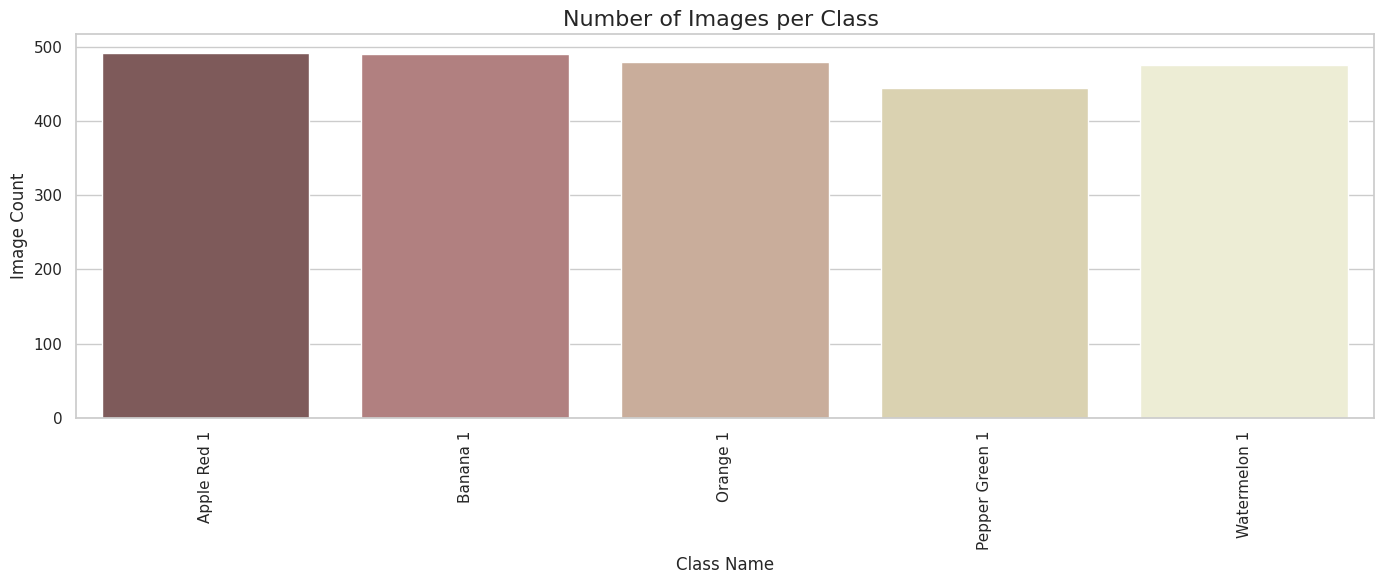

In [14]:
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")
sns.barplot(x=list(image_counts.keys())[:5], y=list(image_counts.values())[:5], palette="pink")
plt.xticks(rotation=90)
plt.title("Number of Images per Class ", fontsize=16)
plt.ylabel("Image Count")
plt.xlabel("Class Name")
plt.tight_layout()
plt.show()

# **General preprocessing step (Resizing the images):**

In [15]:
IMG_SIZE = 128

# **Show Sample Image**

In [16]:
sample_images = []
sample_labels = []

for _ in range(9):
    cls = random.choice(class_names)
    img_path = random.choice(glob.glob(os.path.join(TRAIN_DIR, cls, "*.jpg")))
    img = Image.open(img_path).resize((128, 128))
    sample_images.append(np.array(img))
    sample_labels.append(cls)

#Plot them
fig = make_subplots(rows=3, cols=3, subplot_titles=sample_labels)

idx = 0
for i in range(1, 4):
    for j in range(1, 4):
        fig.add_trace(
            go.Image(z=sample_images[idx]),
            row=i, col=j
        )
        idx += 1
fig.update_layout(
    height=900,
    width=900,
    title={
        'text': "Random Samples from Fruits & Vegetables Dataset",
        'x': 0.5,  # Center align
        'xanchor': 'center'
    }
)
fig.show()

# **1. Preprocessing and Image Enhancement**

## **Show a Sample Original Image**

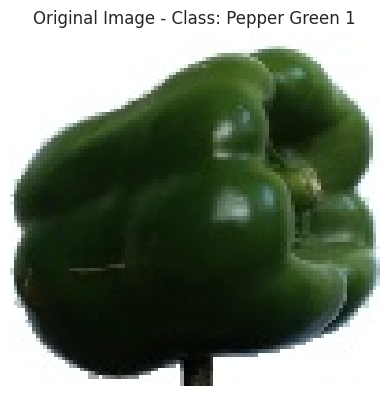

In [17]:
# Pick one random image path from training set
original = random.choice(class_names)
sample_path = random.choice(os.listdir(os.path.join(TRAIN_DIR, original)))
sample_image_path = os.path.join(TRAIN_DIR, original, sample_path)

# Load & show original image
img = Image.open(sample_image_path)
plt.imshow(img)
plt.title(f"Original Image - Class: {original}")
plt.axis("off")
plt.show()

## **Resize a sample**

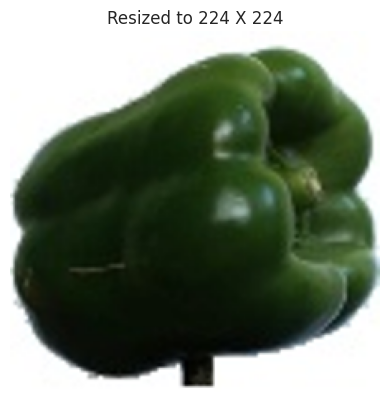

In [18]:
# Resize function for one image
IMG_SIZE = (224,224)
def resize_image(img):
    return img.resize(IMG_SIZE)

# Resize sample image and display
resized_img = resize_image(img)
plt.imshow(resized_img)
plt.title("Resized to 224 X 224")
plt.axis("off")
plt.show()

## **Convert to array & normalize**

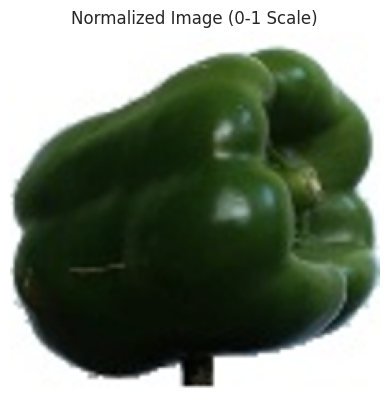

In [19]:
# Convert to array & normalize
normalized_img = np.array(resized_img) / 255.0

# Show using matplotlib (re-convert to image)
plt.imshow(normalized_img)
plt.title("Normalized Image (0-1 Scale)")
plt.axis("off")
plt.show()

# Convert To gray scale

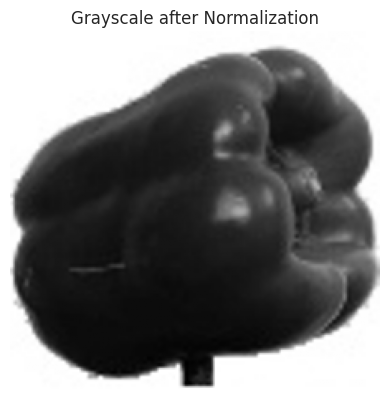

In [20]:
# Step: Convert normalized RGB image to grayscale (single channel)
gray = cv2.cvtColor((normalized_img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

# Show grayscale image
plt.imshow(gray, cmap='gray')
plt.title("Grayscale after Normalization")
plt.axis("off")
plt.show()

## **Apply Gaussian blur**

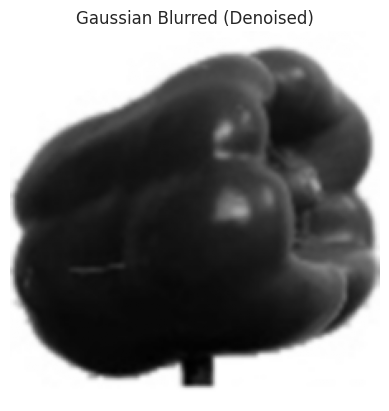

In [21]:
# Apply Gaussian Blur on grayscale image
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Show result
plt.imshow(blurred, cmap='gray')
plt.title("Gaussian Blurred (Denoised)")
plt.axis("off")
plt.show()


# **Make** Light Sharpening after bluring

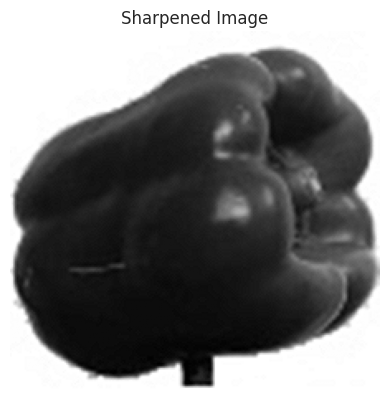

In [22]:
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
sharpened = cv2.filter2D(blurred, -1, kernel)

plt.imshow(sharpened, cmap="gray")
plt.title("Sharpened Image")
plt.axis("off")
plt.show()

# **Contrast Adjustment**

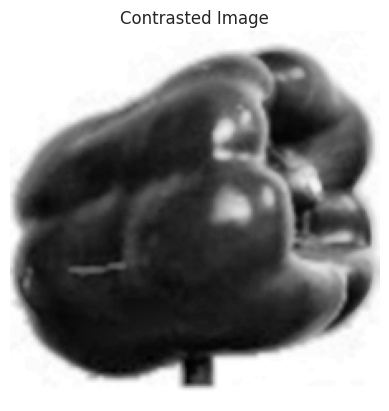

In [23]:

clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
contrasted = clahe.apply(blurred)

plt.imshow(contrasted, cmap='gray')
plt.title("Contrasted Image")
plt.axis("off")
plt.show()

# **Augmentation**

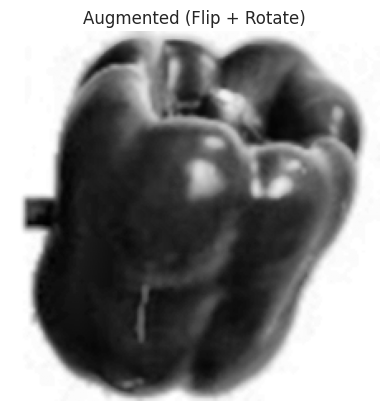

In [24]:
flipped = cv2.flip(contrasted, 1)  # Horizontal flip
augmented = cv2.rotate(flipped, cv2.ROTATE_90_CLOCKWISE)

plt.imshow(augmented, cmap="gray")
plt.title("Augmented (Flip + Rotate)")
plt.axis("off")
plt.show()

# **Thresholding**

# **1) Otsu**

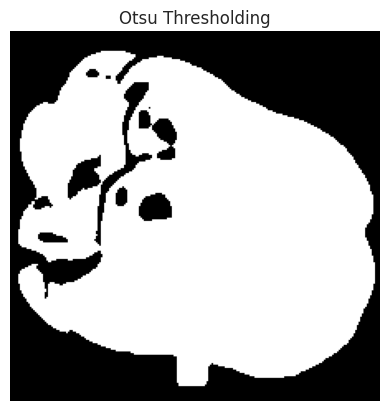

In [25]:
# Reverse rotate (rotate 90° counter-clockwise)
unrotated = cv2.rotate(augmented, cv2.ROTATE_90_COUNTERCLOCKWISE)

# Reverse flip (horizontal flip again to restore original)
original_restored = cv2.flip(unrotated, 1)

# Step 3: Otsu's Thresholding
_, otsu_thresh = cv2.threshold(
    unrotated, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
)

# Step 4: Show Otsu threshold result
plt.imshow(otsu_thresh, cmap='gray')
plt.title("Otsu Thresholding")
plt.axis("off")
plt.show()

# **2) Adapptive**

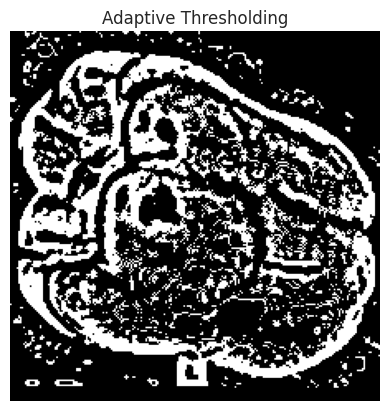

In [26]:
# Reverse rotate (rotate 90° counter-clockwise)
unrotated = cv2.rotate(augmented, cv2.ROTATE_90_COUNTERCLOCKWISE)

# Reverse flip (horizontal flip again to restore original)
original_restored = cv2.flip(unrotated, 1)

adaptive_thresh = cv2.adaptiveThreshold(
    unrotated,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=11,
    C=2
)


# Step 3: Show thresholded image (enhanced)
plt.imshow(adaptive_thresh, cmap='gray')
plt.title("Adaptive Thresholding")
plt.axis("off")
plt.show()

# **Morphological Operations (Lets Choose what is the best)**

# **1)Erosion**

# **On Adaptive**

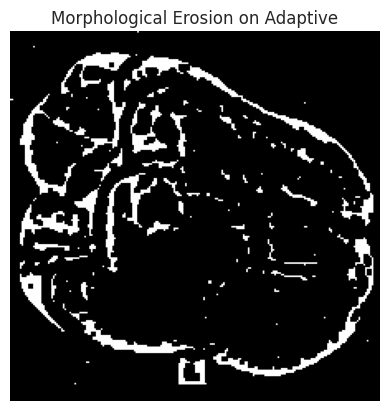

In [27]:
kernel = np.ones((3, 3), np.uint8)

# Apply erosion on the binary thresholded image
eroded_img = cv2.erode(adaptive_thresh, kernel, iterations=1)

# Visualize
plt.imshow(eroded_img, cmap='gray')
plt.title("Morphological Erosion on Adaptive")
plt.axis("off")
plt.show()

# **On otsu**

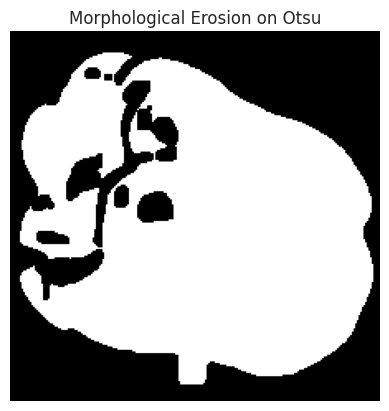

In [28]:
kernel = np.ones((3, 3), np.uint8)

# Apply erosion on the binary thresholded image
eroded_img = cv2.erode(otsu_thresh, kernel, iterations=1)

# Visualize
plt.imshow(eroded_img, cmap='gray')
plt.title("Morphological Erosion on Otsu")
plt.axis("off")
plt.show()

# **2) Dilation**

# **on adaptive**

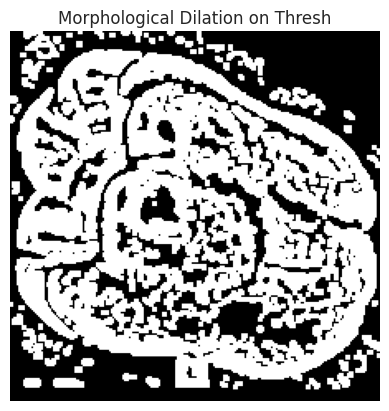

In [29]:
# Define kernel
kernel = np.ones((3, 3), np.uint8)

# Apply dilation on binary mask
dilated_img = cv2.dilate(adaptive_thresh, kernel, iterations=1)

# Show result
plt.imshow(dilated_img, cmap='gray')
plt.title("Morphological Dilation on Thresh")
plt.axis("off")
plt.show()

# **on otsu**

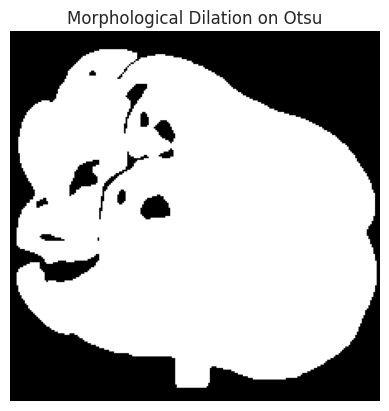

In [30]:
# Define kernel
kernel = np.ones((3, 3), np.uint8)

# Apply dilation on binary mask
dilated_img = cv2.dilate(otsu_thresh, kernel, iterations=1)

# Show result
plt.imshow(dilated_img, cmap='gray')
plt.title("Morphological Dilation on Otsu")
plt.axis("off")
plt.show()


# **3) Closing**

# **on adaptive**

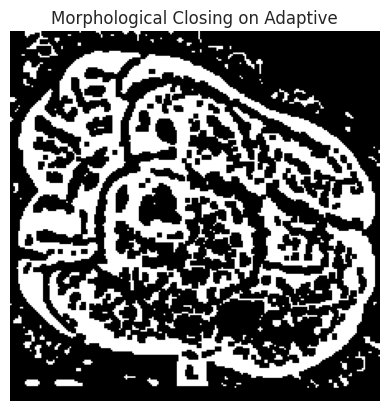

In [31]:
# Define kernel
kernel = np.ones((3, 3), np.uint8)

# Apply morphological closing (dilate → erode)
closed_img_ada = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel)

# Show result
plt.imshow(closed_img_ada, cmap='gray')
plt.title("Morphological Closing on Adaptive")
plt.axis("off")
plt.show()

# **on otsu**

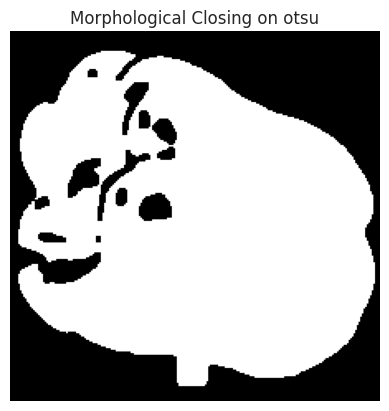

In [32]:
# Define kernel
kernel = np.ones((3, 3), np.uint8)

# Apply morphological closing (dilate → erode)
closed_img_otsu = cv2.morphologyEx(otsu_thresh, cv2.MORPH_CLOSE, kernel)

# Show result
plt.imshow(closed_img_otsu, cmap='gray')
plt.title("Morphological Closing on otsu")
plt.axis("off")
plt.show()

# **4)Opening**

# **On adaptive**

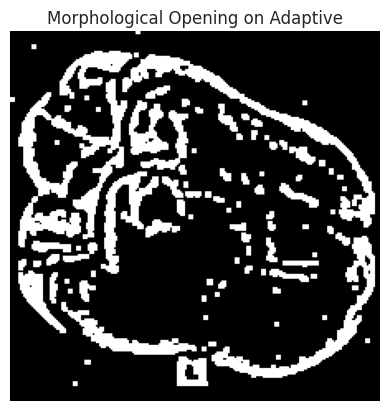

In [33]:
kernel = np.ones((3, 3), np.uint8)
open_ada = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_OPEN, kernel)

plt.imshow(open_ada, cmap='gray')
plt.title("Morphological Opening on Adaptive")
plt.axis("off")
plt.show()

# **On Otsu**

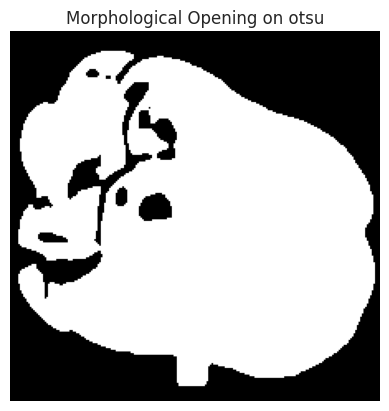

In [34]:
kernel = np.ones((3, 3), np.uint8)
open_otsu = cv2.morphologyEx(otsu_thresh, cv2.MORPH_OPEN, kernel)

plt.imshow(open_otsu, cmap='gray')
plt.title("Morphological Opening on otsu")
plt.axis("off")
plt.show()

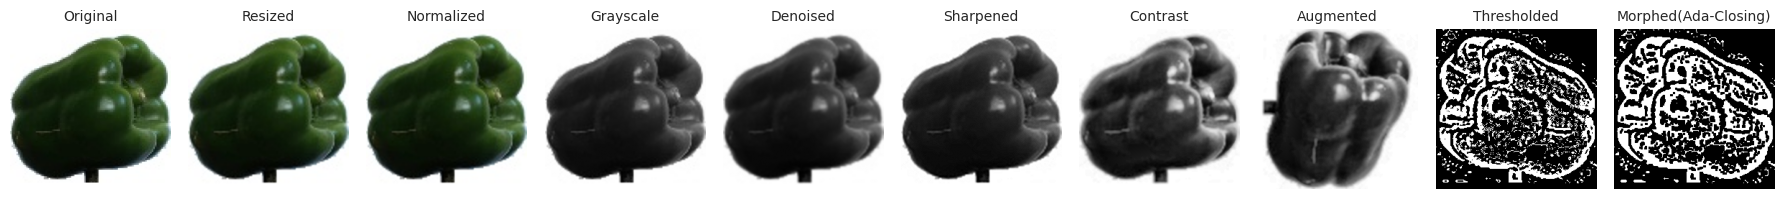

In [35]:
original = np.array(Image.open(sample_image_path))

def show_all(images, titles):
    import matplotlib.pyplot as plt
    import numpy as np
    from PIL import Image

    plt.figure(figsize=(18, 4))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)

        try:
            # Auto-convert from string or PIL
            if isinstance(img, str):
                img = np.array(Image.open(img))
            elif isinstance(img, Image.Image):
                img = np.array(img)

            # Convert normalized float [0–1] to uint8
            if isinstance(img, np.ndarray):
                if img.max() <= 1.0:
                    img = (img * 255).astype(np.uint8)

                # Grayscale detection
                cmap = 'gray' if len(img.shape) == 2 else None
                plt.imshow(img, cmap=cmap)
            else:
                raise TypeError("Invalid image type")

        except Exception as e:
            print(f"⚠️ Skipped '{title}': {e}")
            plt.imshow(np.ones((10, 10)), cmap='gray')  # dummy image

        plt.title(title, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_all(
    [original, resized_img, normalized_img, gray, blurred,sharpened, contrasted, augmented, adaptive_thresh ,closed_img_ada],
    ["Original", "Resized","Normalized", "Grayscale", "Denoised", "Sharpened", "Contrast", "Augmented", "Thresholded", "Morphed(Ada-Closing)"]
)

# **Make all of preprocessing steps on all of the Dataset**

In [36]:
# Input and output directories
Preprocessed_all_steps = "/content/fruits-360_100x100/fruits-360/Preprocessed_all_steps"
os.makedirs(Preprocessed_all_steps, exist_ok=True)

# Preprocessing parameters
IMG_SIZE = (224, 224)
MORPH_KERNEL = np.ones((3, 3), np.uint8)
SHARPEN_KERNEL = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])

# Preprocessing pipeline for each image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMG_SIZE)

    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Normalize [0,1]
    norm_gray = gray.astype(np.float32) / 255.0

    # Denoise
    denoised = cv2.GaussianBlur((norm_gray * 255).astype(np.uint8), (5, 5), 0)

    # Sharpen (remains grayscale)
    sharpened = cv2.filter2D(denoised, -1, SHARPEN_KERNEL)

    # Contrast enhancement (CLAHE on grayscale)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast = clahe.apply(sharpened)

    # Adaptive Thresholding
    thresholded = cv2.adaptiveThreshold(
        contrast,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY_INV,
        blockSize=11,
        C=2
    )

    # Morphological Closing
    # morphed = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, MORPH_KERNEL)

    # Convert to 3-channel RGB for saving/consistency
    final_rgb = cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB)

    return final_rgb

# Process all images and save
for class_name in os.listdir(TRAIN_DIR):
    class_path = os.path.join(TRAIN_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    output_class_dir = os.path.join(Preprocessed_all_steps, class_name)
    os.makedirs(output_class_dir, exist_ok=True)

    for img_name in tqdm(os.listdir(class_path), desc=f"Processing: {class_name}"):
        img_path = os.path.join(class_path, img_name)
        output_path = os.path.join(output_class_dir, img_name)

        processed_img = preprocess_image(img_path)
        if processed_img is not None:
            Image.fromarray(processed_img).save(output_path)


Processing: Apple Red 1: 100%|██████████| 492/492 [00:02<00:00, 176.71it/s]


# **Randomly select and display an image**

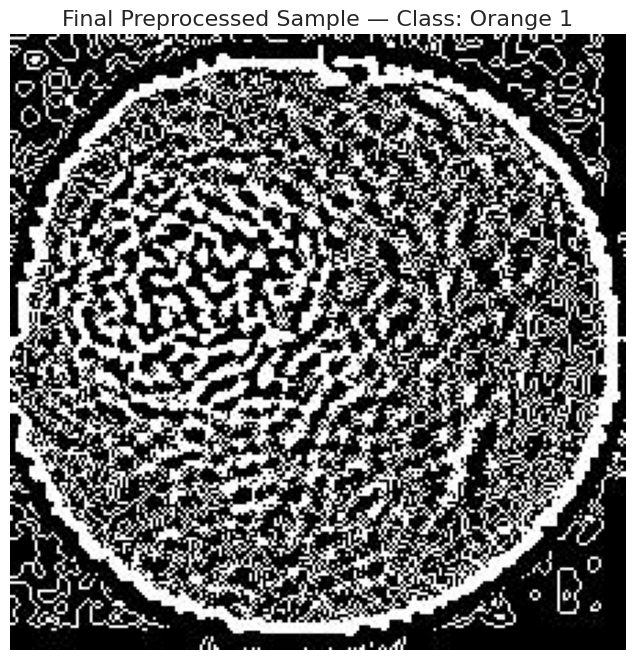

In [37]:
def display_random_image(output_dir):

    # Randomly select a class folder
    sample_class = random.choice(os.listdir(output_dir))
    sample_class_path = os.path.join(output_dir, sample_class)

    # Randomly select an image from the chosen class folder
    sample_image_name = random.choice(os.listdir(sample_class_path))
    sample_img_path = os.path.join(sample_class_path, sample_image_name)

    # Load and preprocess the image
    sample_img = cv2.imread(sample_img_path)
    if sample_img is None:
        print(f"Error: Unable to load image at {sample_img_path}")
        return

    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Display the image using Matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(sample_img)
    plt.title(f'Final Preprocessed Sample — Class: {sample_class}', fontsize=16)
    plt.axis('off')  # Turn off axis
    plt.show()

display_random_image(Preprocessed_all_steps)

# **2. Segmentation**

## **Now we are trying all segmentation techniques (mentioned in the PDF) to show which will output the best result:**

Testing on image: /content/fruits-360_100x100/fruits-360/Preprocessed_all_steps/Watermelon 1/r_281_100.jpg


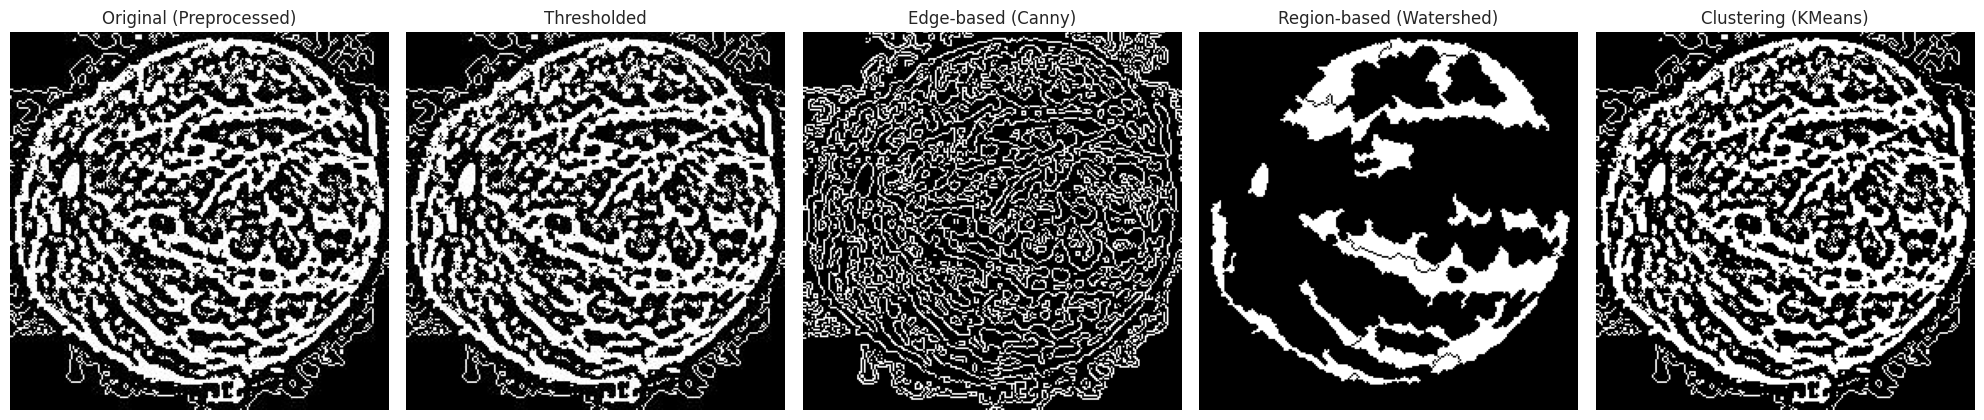

In [38]:
# Segmentation methods
def edge_based_segmentation(image_gray):
    edges = cv2.Canny(image_gray, 100, 200)
    return edges

def region_based_segmentation(image_gray):
    kernel = np.ones((3, 3), np.uint8)
    sure_bg = cv2.dilate(image_gray, kernel, iterations=3)

    dist_transform = cv2.distanceTransform(image_gray, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    color_image = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(color_image, markers)
    segmented = np.zeros_like(image_gray)
    segmented[markers > 1] = 255

    return segmented

def clustering_segmentation(image_rgb):
    Z = image_rgb.reshape((-1, 3))
    Z = np.float32(Z)

    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    labels = kmeans.fit_predict(Z)
    clustered = labels.reshape((image_rgb.shape[:2]))
    clustered_img = np.uint8(clustered * 255)

    return clustered_img

# Select random image
def pick_random_image(folder):
    class_dirs = [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]
    chosen_class = random.choice(class_dirs)
    chosen_dir = os.path.join(folder, chosen_class)

    img_files = os.listdir(chosen_dir)
    chosen_img = random.choice(img_files)
    img_path = os.path.join(chosen_dir, chosen_img)

    return img_path

# Apply and visualize all segmentation methods
def test_segmentation(image_path):
    print(f"Testing on image: {image_path}")

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    thresholded = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # already thresholded image

    # Apply segmentation methods
    edge_seg = edge_based_segmentation(thresholded)
    region_seg = region_based_segmentation(thresholded)
    cluster_seg = clustering_segmentation(image)

    # Visualization
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))

    axs[0].imshow(image)
    axs[0].set_title("Original (Preprocessed)")
    axs[0].axis('off')

    axs[1].imshow(thresholded, cmap='gray')
    axs[1].set_title("Thresholded")
    axs[1].axis('off')

    axs[2].imshow(edge_seg, cmap='gray')
    axs[2].set_title("Edge-based (Canny)")
    axs[2].axis('off')

    axs[3].imshow(region_seg, cmap='gray')
    axs[3].set_title("Region-based (Watershed)")
    axs[3].axis('off')

    axs[4].imshow(cluster_seg, cmap='gray')
    axs[4].set_title("Clustering (KMeans)")
    axs[4].axis('off')

    plt.tight_layout()
    plt.show()

# Run test
random_img = pick_random_image(Preprocessed_all_steps)
test_segmentation(random_img)

# **Show it in RGB to show that it is more useful to be feeded into CNN**

Selected image: /content/fruits-360_100x100/fruits-360/Training_5/Watermelon 1/r_218_100.jpg


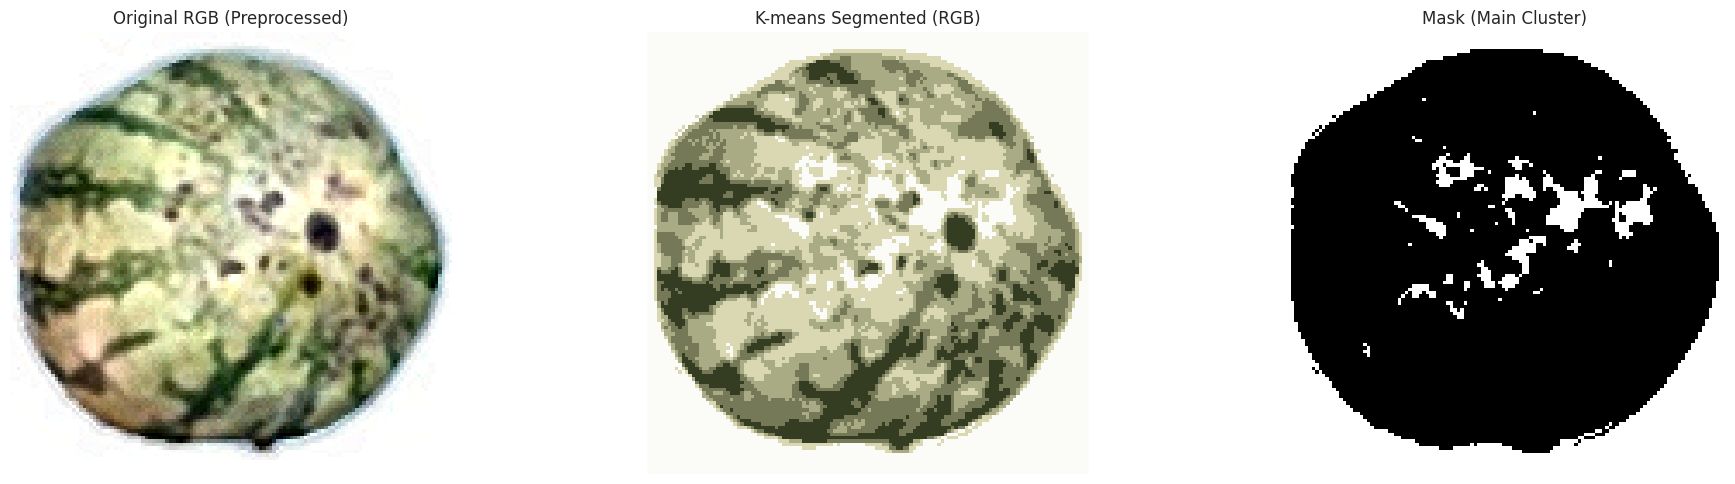

In [39]:
# Preprocessing constants
IMG_SIZE = (128, 128)
SHARPEN_KERNEL = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

# Step 1: Full preprocessing in RGB (excluding grayscale/thresholding)
def preprocess_rgb(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    image = cv2.resize(image, IMG_SIZE)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Noise reduction
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Contrast enhancement (CLAHE per channel)
    lab = cv2.cvtColor(blurred, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    contrast = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # Sharpening
    sharpened = cv2.filter2D(contrast, -1, SHARPEN_KERNEL)

    return sharpened

# Step 2: Apply K-means clustering on RGB
def kmeans_segmentation_with_mask(image_rgb, k=5):
    Z = image_rgb.reshape((-1, 3)).astype(np.float32)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(Z)
    centers = np.uint8(kmeans.cluster_centers_)
    segmented = centers[labels].reshape(image_rgb.shape)

    # Choose largest cluster as mask (excluding background)
    label_counts = np.bincount(labels)
    main_cluster = np.argmax(label_counts)
    mask = (labels.reshape(image_rgb.shape[:2]) == main_cluster).astype(np.uint8) * 255

    return segmented, mask

def run_kmeans_segmentation_with_box():
    # Pick random image from train folder
    classes = [d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))]
    chosen_class = random.choice(classes)
    chosen_dir = os.path.join(TRAIN_DIR, chosen_class)
    image_name = random.choice(os.listdir(chosen_dir))
    image_path = os.path.join(chosen_dir, image_name)

    print(f"Selected image: {image_path}")

    # Preprocess in RGB
    rgb_image = preprocess_rgb(image_path)
    if rgb_image is None:
        print("Image load failed.")
        return

    # Apply K-means and get mask
    segmented_image, mask = kmeans_segmentation_with_mask(rgb_image, k=5)


    # Visualization
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    axs[0].imshow(rgb_image)
    axs[0].set_title("Original RGB (Preprocessed)")
    axs[0].axis('off')

    axs[1].imshow(segmented_image)
    axs[1].set_title("K-means Segmented (RGB)")
    axs[1].axis('off')

    axs[2].imshow(mask, cmap='gray')
    axs[2].set_title("Mask (Main Cluster)")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

# Run
run_kmeans_segmentation_with_box()

# **So we make Preprocessing steps on RGB Which fit our Dataset and model**

In [40]:


# Define input (raw) and output (preprocessed) directories
PREPROCESSED_RGB_DIR = "/content/fruits-360_100x100/fruits-360/preprocessed_RGB"
os.makedirs(PREPROCESSED_RGB_DIR, exist_ok=True)

def preprocessing_RGB(image_path, target_size=(128, 128)):
    # Load image from disk
    image = cv2.imread(image_path)
    if image is None:
        return None

    # Resize image to target CNN size
    image = cv2.resize(image, target_size)

    # Convert image to RGB from BGR
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply Gaussian Blur to reduce noise
    image = cv2.GaussianBlur(image, (5, 5), 0)

    # Convert image to LAB color space for contrast enhancement
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L channel to enhance local contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab = cv2.merge((l_clahe, a, b))

    # Convert LAB image back to RGB
    image = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # Apply sharpening kernel to enhance edges/details
    sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, sharpen_kernel)

    # Normalize pixel values to [0, 1] range for deep learning input
    image = image.astype(np.float32) / 255.0

    return image

def preprocess_all_train_images():
    # Loop through all class folders in the training directory
    for class_name in os.listdir(TRAIN_DIR):
        class_path = os.path.join(TRAIN_DIR, class_name)
        if not os.path.isdir(class_path):
            continue

        # Create output folder for each class
        output_class_dir = os.path.join(PREPROCESSED_RGB_DIR, class_name)
        os.makedirs(output_class_dir, exist_ok=True)

        # Process each image in the class folder
        for img_file in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
            input_img_path = os.path.join(class_path, img_file)
            output_img_path = os.path.join(output_class_dir, img_file)

            # Apply preprocessing
            processed_img = preprocessing_RGB(input_img_path)
            if processed_img is not None:
                # Convert normalized image back to uint8 for saving
                Image.fromarray((processed_img * 255).astype(np.uint8)).save(output_img_path)

# Execute the preprocessing pipeline
preprocess_all_train_images()

Processing Apple Red 1: 100%|██████████| 492/492 [00:01<00:00, 396.07it/s]


# **Visualize a random image from Preprocessed_RGB folder**

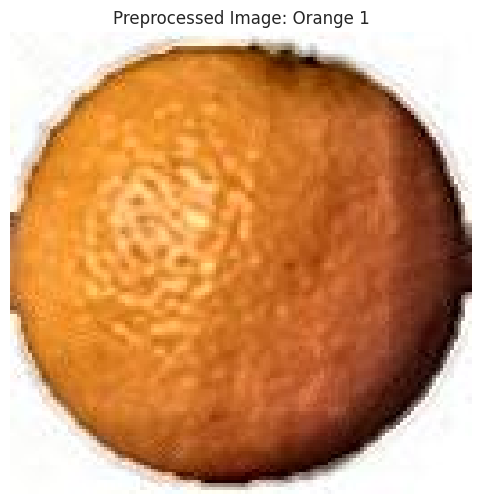

In [41]:
def show_random_preprocessed_image():
    class_dirs = os.listdir(PREPROCESSED_RGB_DIR)
    chosen_class = random.choice(class_dirs)
    img_name = random.choice(os.listdir(os.path.join(PREPROCESSED_RGB_DIR, chosen_class)))
    img_path = os.path.join(PREPROCESSED_RGB_DIR, chosen_class, img_name)

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Preprocessed Image: {chosen_class}")
    plt.axis('off')
    plt.show()

# Run
show_random_preprocessed_image()

# **Segment preprocessed RGB images with K-Means and save to Pre_Seg_RGB folder**

## **Efficient K-Means Segmentation with MiniBatchKMeans**

In [42]:
from sklearn.cluster import MiniBatchKMeans

# Path
PRE_SEG_RGB_DIR = "/content/fruits-360_100x100/fruits-360/Pre_Seg_RGB"
os.makedirs(PRE_SEG_RGB_DIR, exist_ok=True)

# MiniBatchKMeans segmentation function
def segment_kmeans_fast(image, k=5):
    Z = image.reshape((-1, 3)).astype(np.float32)

    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=42)
    labels = kmeans.fit_predict(Z)
    centers = np.uint8(kmeans.cluster_centers_)
    segmented = centers[labels].reshape(image.shape)

    return segmented

# Apply KMeans segmentation on preprocessed RGB images
def segment_all_preprocessed():
    for class_name in os.listdir(PREPROCESSED_RGB_DIR):
        input_class_dir = os.path.join(PREPROCESSED_RGB_DIR, class_name)
        output_class_dir = os.path.join(PRE_SEG_RGB_DIR, class_name)
        os.makedirs(output_class_dir, exist_ok=True)

        for image_name in tqdm(os.listdir(input_class_dir), desc=f"KMeans Segmentation: {class_name}"):
            img_path = os.path.join(input_class_dir, image_name)
            image = cv2.imread(img_path)
            if image is None:
                continue

            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            segmented = segment_kmeans_fast(image_rgb, k=5)

            save_path = os.path.join(output_class_dir, image_name)
            Image.fromarray(segmented).save(save_path)

# Run segmentation
segment_all_preprocessed()

KMeans Segmentation: Apple Red 1: 100%|██████████| 492/492 [00:05<00:00, 82.00it/s]


# **Visualize a Random Image from Pre_Seg_RGB**

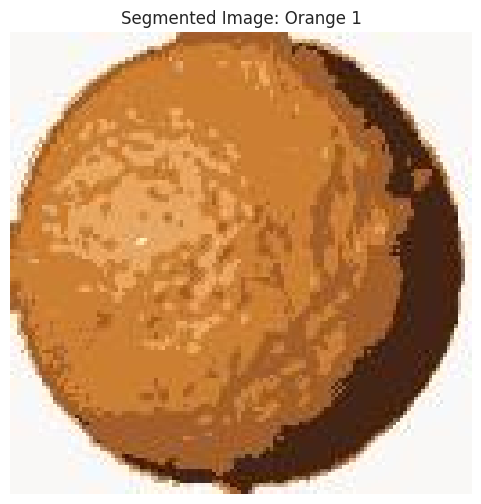

In [43]:
def show_random_segmented_image(segmented_dir):
    class_dirs = [d for d in os.listdir(segmented_dir) if os.path.isdir(os.path.join(segmented_dir, d))]
    chosen_class = random.choice(class_dirs)
    class_path = os.path.join(segmented_dir, chosen_class)

    image_name = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_name)

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.title(f"Segmented Image: {chosen_class}")
    plt.axis('off')
    plt.show()

# Run the function on Pre_Seg_RGB
show_random_segmented_image(PRE_SEG_RGB_DIR)

# **3. Feature Extraction Using SIFT on pre_seg_RGB**

In [44]:
SIFT_FEATURES_DIR = "/content/fruits-360_100x100/fruits-360/SIFT_Features"
os.makedirs(SIFT_FEATURES_DIR, exist_ok=True)

In [45]:
sift = cv2.SIFT_create()

def extract_sift(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return descriptors

def extract_sift_from_all():
    for class_name in os.listdir(PRE_SEG_RGB_DIR):
        class_path = os.path.join(PRE_SEG_RGB_DIR, class_name)
        if not os.path.isdir(class_path):
            continue

        out_class_dir = os.path.join(SIFT_FEATURES_DIR, class_name)
        os.makedirs(out_class_dir, exist_ok=True)

        for img_name in tqdm(os.listdir(class_path), desc=f"SIFT: {class_name}"):
            img_path = os.path.join(class_path, img_name)
            desc = extract_sift(img_path)
            if desc is not None:
                np.save(os.path.join(out_class_dir, img_name.replace(".jpg", ".npy")), desc)
extract_sift_from_all()

SIFT: Apple Red 1: 100%|██████████| 492/492 [00:06<00:00, 77.73it/s]


# **Visualize SIFT Keypoints on Fruit Only**

In [46]:
def visualize_sift_keypoints():
    class_dirs = os.listdir(PRE_SEG_RGB_DIR)
    chosen_class = random.choice(class_dirs)
    img_name = random.choice(os.listdir(os.path.join(PRE_SEG_RGB_DIR, chosen_class)))
    img_path = os.path.join(PRE_SEG_RGB_DIR, chosen_class, img_name)

    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kp = sift.detect(gray, None)
    img_kp = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
    plt.title(f"SIFT Keypoints on {chosen_class}: {len(kp)} detected")
    plt.axis('off')
    plt.show()

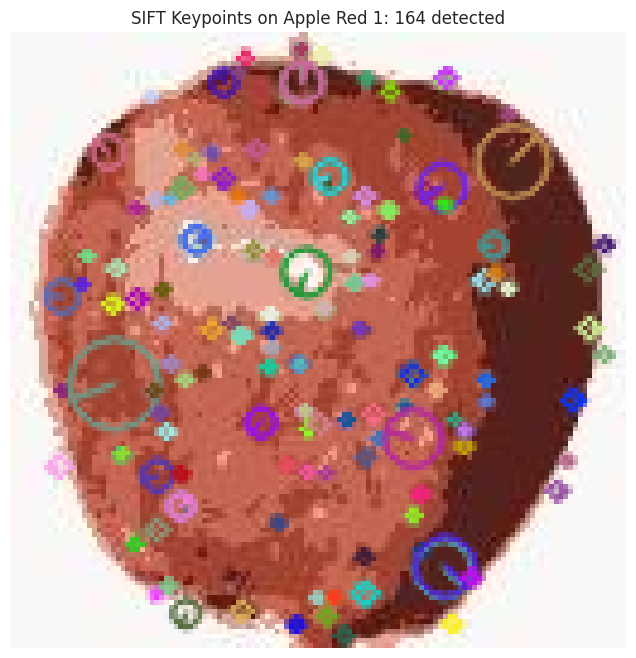

In [47]:
visualize_sift_keypoints()

# **3. BoVW + SVM Pipeline**

## **Prepare label map**

In [48]:
# Configuration
VOCAB_SIZE = 100
MAX_DESC_PER_IMAGE = 100

In [49]:
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import os
from tqdm import tqdm

# Initialize variables before loop
label_map = {}
label_counter = 0
all_descriptors = []
image_labels = []

MAX_DESC_PER_IMAGE = 200  # Or any limit you'd like


print("Loading SIFT descriptors...")

for class_name in tqdm(os.listdir(SIFT_FEATURES_DIR)):
    class_dir = os.path.join(SIFT_FEATURES_DIR, class_name)
    if not os.path.isdir(class_dir):
        continue

    if class_name not in label_map:
        label_map[class_name] = label_counter
        label_counter += 1
    label = label_map[class_name]

    for fname in os.listdir(class_dir):
        desc_path = os.path.join(class_dir, fname)
        descriptors = np.load(desc_path)

        if descriptors is None or len(descriptors) == 0:
            continue

        # Limit descriptor count
        descriptors = descriptors[:MAX_DESC_PER_IMAGE]
        all_descriptors.append(descriptors)
        image_labels.append(label)

Loading SIFT descriptors...


100%|██████████| 5/5 [00:00<00:00, 11.47it/s]


## **Fit MiniBatchKMeans incrementally (no stacking)**

In [50]:
# Step 2: Fit MiniBatchKMeans
print("Fitting MiniBatchKMeans (BoVW)...")
kmeans = MiniBatchKMeans(n_clusters=VOCAB_SIZE, random_state=42, batch_size=256)

for desc in tqdm(all_descriptors, desc="Fitting"):
    kmeans.partial_fit(desc.astype(np.float32))

Fitting MiniBatchKMeans (BoVW)...


Fitting: 100%|██████████| 2380/2380 [00:02<00:00, 1041.65it/s]


## **Build histograms for each image**

In [51]:
# Define histogram function before using it
def build_bovw_histogram(descriptors, kmeans_model):
    words = kmeans_model.predict(descriptors)
    histogram = np.bincount(words, minlength=kmeans_model.n_clusters)
    histogram = histogram.astype(np.float32)
    histogram /= np.sum(histogram)  # Normalize
    return histogram

# Now use it
print("Building BoVW histograms...")
X = [build_bovw_histogram(d, kmeans) for d in all_descriptors]
y = image_labels

Building BoVW histograms...


# **BoVW Histogram Visualization Code**

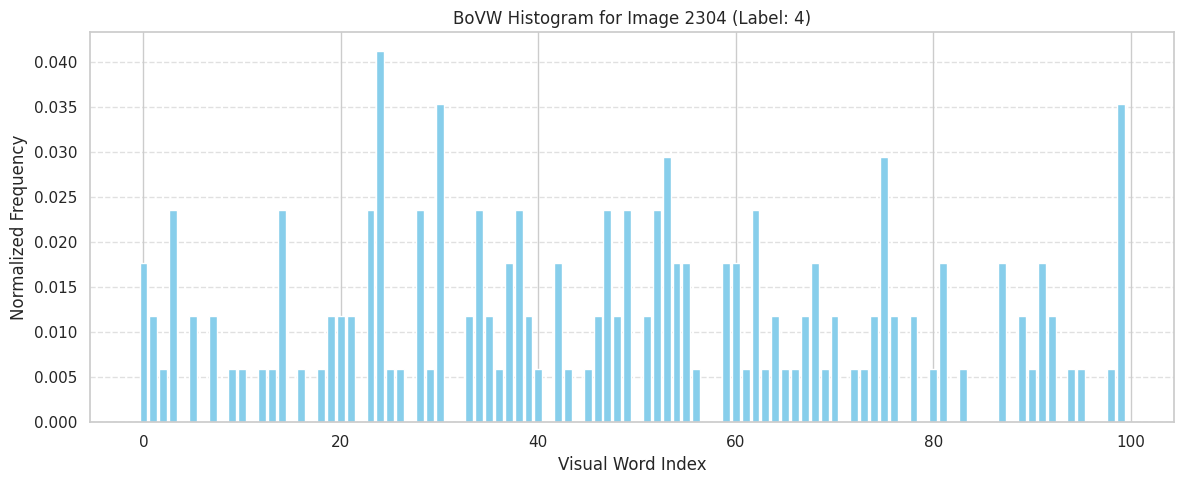

In [52]:
# Choose a random index from the data
random_idx = random.randint(0, len(X) - 1)
hist = X[random_idx]
label = y[random_idx]

# Plot the histogram
plt.figure(figsize=(12, 5))
plt.bar(range(len(hist)), hist, color='skyblue')
plt.title(f"BoVW Histogram for Image {random_idx} (Label: {label})")
plt.xlabel("Visual Word Index")
plt.ylabel("Normalized Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## **Train/Test Split**

In [53]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

# Step 4: Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 5: Train SVM
print("Training Linear SVM...")
svm_model = LinearSVC(C=1.0, max_iter=10000, random_state=42)
svm_model.fit(X_train, y_train)

Training Linear SVM...


LinearSVC(max_iter=10000, random_state=42)

In [54]:
from joblib import dump
dump(svm_model, "svm_model.joblib")

['svm_model.joblib']

# **Evaluation**

Classification Report:
                precision    recall  f1-score   support

Pepper Green 1       1.00      0.98      0.99        89
  Watermelon 1       1.00      1.00      1.00        95
      Orange 1       0.98      1.00      0.99        96
      Banana 1       0.99      1.00      0.99        98
   Apple Red 1       0.99      0.98      0.98        98

      accuracy                           0.99       476
     macro avg       0.99      0.99      0.99       476
  weighted avg       0.99      0.99      0.99       476

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        89
           1       1.00      1.00      1.00        95
           2       0.98      1.00      0.99        96
           3       0.99      1.00      0.99        98
           4       0.99      0.98      0.98        98

    accuracy                           0.99       476
   macro avg       0.99      0.99      0.99       476
weighted avg       0.99      0.99   

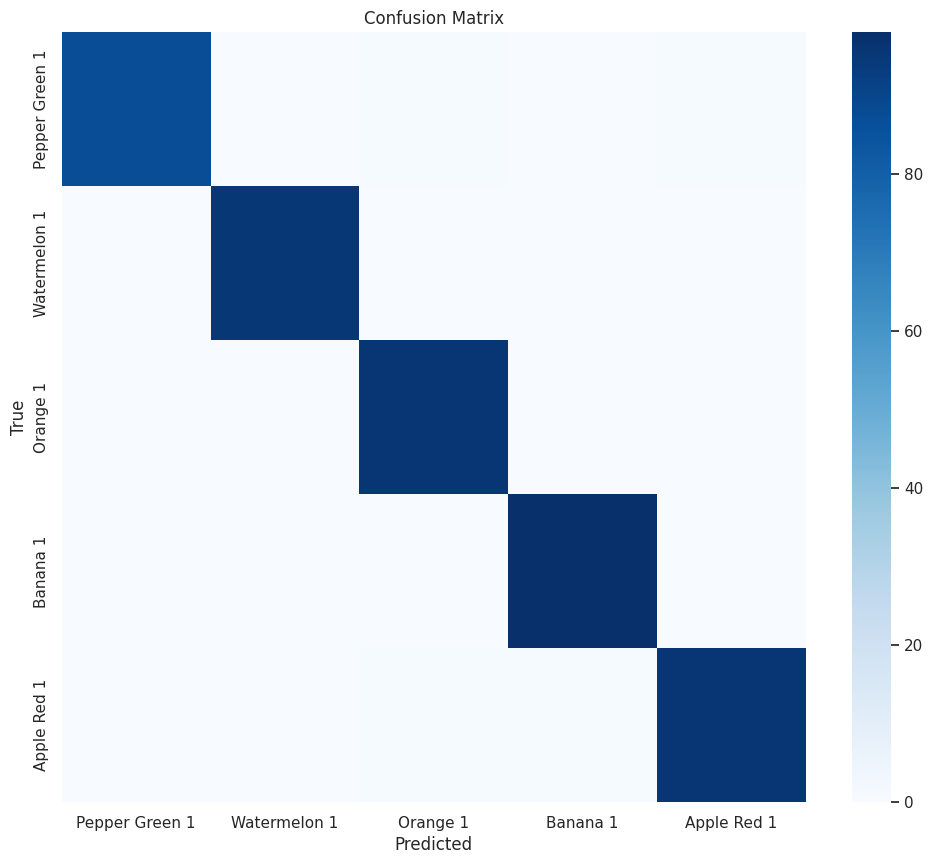

In [55]:
from sklearn.metrics import classification_report, confusion_matrix  # For evaluation metrics
from sklearn.metrics import accuracy_score
y_pred = svm_model.predict(X_test)

from sklearn.metrics import classification_report

# Sort by label ID to match order of label_map
sorted_labels = sorted(set(y_test))  # Only the labels that appeared in test
sorted_names = [name for name, idx in sorted(label_map.items(), key=lambda x: x[1]) if idx in sorted_labels]

print("Classification Report:")
print(classification_report(
    y_test,
    y_pred,
    labels=sorted_labels,
    target_names=sorted_names
))

print(classification_report(
    y_test,
    y_pred,
    target_names=[str(l) for l in np.unique(y_test)]
))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_map.keys()))

# Step 7: Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=label_map.keys(),
            yticklabels=label_map.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ***CNN from scratch :***

## **1: Load pre_seg Dataset**

In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [57]:
# Parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Directories
PRE_SEG_DIR = "/content/fruits-360_100x100/fruits-360/Pre_Seg_RGB"

# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,           # randomly rotate images by 0–20 degrees
    width_shift_range=0.1,       # shift images horizontally (10%)
    height_shift_range=0.1,      # shift images vertically (10%)
    zoom_range=0.1,              # zoom in/out randomly
    #shear_range=0.1,             # shear transformation
    horizontal_flip=True,        # randomly flip images horizontally
    #fill_mode='nearest'          # fill missing pixels with nearest
)

# Data generators with augmentation for training
train_generator = datagen.flow_from_directory(
    PRE_SEG_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator (no augmentation, just rescaling)
val_generator = datagen.flow_from_directory(
    PRE_SEG_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)
num_classes = len(train_generator.class_indices)
print(f"Detected {num_classes} classes.")
# SAVE the order of classes
class_names = train_generator.class_indices  # dict: {'Apple': 0, 'Banana': 1, ...}
class_names = sorted(class_names, key=lambda x: class_names[x])  # sorted with names

with open("class_names.txt", "w") as f:
    for name in class_names:
        f.write(name + "\n")

Found 1906 images belonging to 5 classes.
Found 474 images belonging to 5 classes.
Detected 5 classes.


## **2: Build CNN Model (from scratch)**

In [58]:
# # Build a simple CNN
# def build_cnn_model(input_shape=(128, 128, 3), num_classes=36):
#     model = models.Sequential()

#     model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
#     model.add(layers.MaxPooling2D((2,2)))

#     model.add(layers.Conv2D(64, (3,3), activation='relu'))
#     model.add(layers.MaxPooling2D((2,2)))

#     model.add(layers.Conv2D(128, (3,3), activation='relu'))
#     model.add(layers.MaxPooling2D((2,2)))

#     model.add(layers.Flatten())

#     model.add(layers.Dense(128, activation='relu'))
#     model.add(layers.Dropout(0.5))

#     model.add(layers.Dense(num_classes, activation='softmax'))

#     return model


# Build a simple CNN
def build_cnn_model(input_shape=(128, 128, 3), num_classes=5):
    model = models.Sequential()

    # 1. Conv + Pool (can also use stride instead of pooling)
    model.add(layers.Conv2D(32, (3, 3), strides=2, activation='relu', input_shape=input_shape))

    # 2. Conv + Pool
    model.add(layers.Conv2D(64, (3, 3), strides=2, activation='relu'))

    # 3. Conv + Pool
    model.add(layers.Conv2D(128, (3, 3), strides=2, activation='relu'))

    # 4. Flatten + Dense
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))

    # 5. Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Build model
cnn_model = build_cnn_model(input_shape=(128,128,3), num_classes=num_classes)
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 63, 63, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 31, 31, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,780,421 (14.42 MB)

 Trainable params: 3,780,421 (14.42 MB)

 Non-trainable params: 0 (0.00 B)

## **3: Compile Model**

In [59]:
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## **4: Train the Model (with EarlyStopping)**

In [60]:
# from tensorflow.keras.callbacks import EarlyStopping

# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# history = cnn_model.fit(
#     train_generator,
#     epochs=50,
#     validation_data=val_generator,
#     callbacks=[early_stop]
# )


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)

history = cnn_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 219ms/step - accuracy: 0.7570 - loss: 0.5887 - val_accuracy: 0.9979 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.9984 - loss: 0.0110 - val_accuracy: 1.0000 - val_loss: 3.6640e-04 - learning_rate: 0.0010
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 199ms/step - accuracy: 0.9976 - loss: 0.0078 - val_accuracy: 0.9620 - val_loss: 0.0897 - learning_rate: 0.0010
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 172ms/step - accuracy: 0.9573 - loss: 0.1288 - val_accuracy: 1.0000 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 1.0000 - loss: 2.3612e-04 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 1.0000 - loss: 1.9404e-04 - val_accuracy: 1.0000 - val_loss: 4.1400e-04 - learning_rate: 3.0000e-04
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 211ms/step - accurac

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step
Classification Report:
                precision    recall  f1-score   support

   Apple Red 1       1.00      1.00      1.00        98
      Banana 1       1.00      1.00      1.00        98
      Orange 1       1.00      1.00      1.00        95
Pepper Green 1       1.00      1.00      1.00        88
  Watermelon 1       1.00      1.00      1.00        95

      accuracy                           1.00       474
     macro avg       1.00      1.00      1.00       474
  weighted avg       1.00      1.00      1.00       474



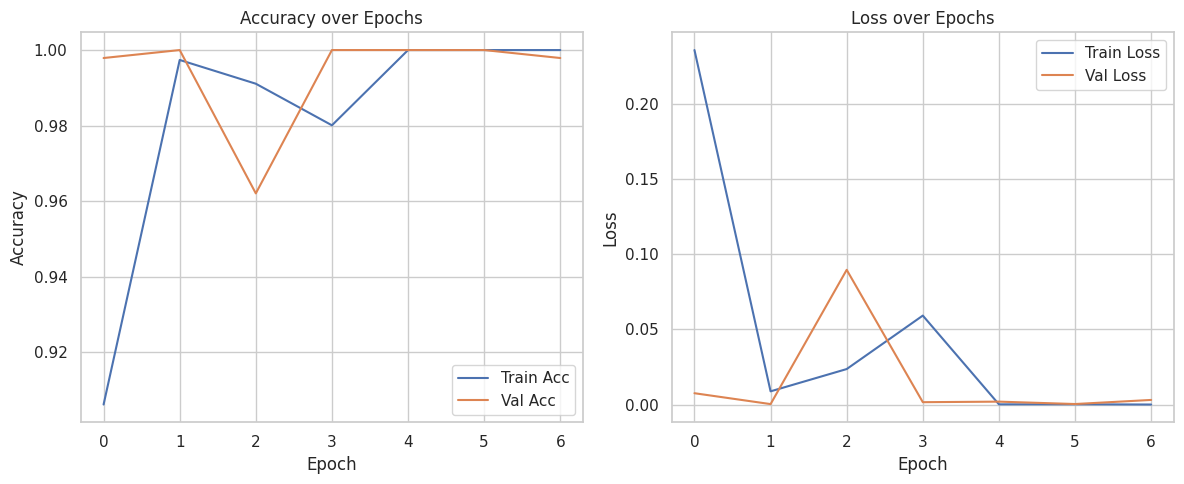

In [61]:
# Predict on validation data
val_generator.reset()
y_pred = cnn_model.predict(val_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(val_generator.class_indices.keys())))

# Plot Accuracy and Loss curves
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [62]:
cnn_model.save("cnn_model.h5")

In [63]:
from google.colab import files
files.download("cnn_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **FINALLYYYYY Lets host a Streamlit GUI ^-^ !**

In [65]:
!pip install streamlit pyngrok --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 123.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.1 MB/s eta 0:00:00


In [67]:
%%writefile app.py
import streamlit as st
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image

# Load trained model
model = load_model("cnn_model.h5")

# Load class names
with open("class_names.txt", "r") as f:
    class_names = [line.strip() for line in f.readlines()]

IMG_SIZE = (128, 128)

def detect_objects(img):
    image = np.array(img.convert("RGB"))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    orig = image.copy()
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w * h < 1000:
            continue

        roi = orig[y:y + h, x:x + w]
        roi_resized = cv2.resize(roi, IMG_SIZE)
        roi_array = img_to_array(roi_resized)
        roi_array = preprocess_input(roi_array)
        roi_array = np.expand_dims(roi_array, axis=0)

        pred = model.predict(roi_array)
        class_idx = np.argmax(pred)
        confidence = np.max(pred)
        label = f"{class_names[class_idx]} ({confidence*100:.1f}%)"

        cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image_rgb, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    return image_rgb

st.title("🍎🍌 Fruit Detector using CNN")
st.write("Upload an image with fruits, and the system will detect and label them.")

uploaded_file = st.file_uploader("Upload Image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image", use_column_width=True)

    if st.button("Detect Fruits"):
        detected_image = detect_objects(image)
        st.image(detected_image, caption="Detected Fruits", use_column_width=True)

Writing app.py


In [69]:
!pip install pyngrok
from pyngrok import ngrok


!streamlit run app.py &>/content/logs.txt &

public_url = ngrok.connect(port=8501)
print(f"🔗 افتحي التطبيق من هنا: {public_url}")


ERROR:pyngrok.process.ngrok:t=2025-05-06T16:15:51+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-05-06T16:15:51+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"


PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

## **Write app.py File**

In [ ]:
# %%writefile app.py
# import streamlit as st
# import numpy as np
# import cv2
# from tensorflow.keras.models import load_model
# from tensorflow.keras.applications.efficientnet import preprocess_input
# from tensorflow.keras.preprocessing.image import img_to_array
# from PIL import Image

# # --- CONFIGURATION ---
# MODEL_PATH = "/content/cnn_model.h5"
# IMG_SIZE = (128, 128)     # Image input size
# WINDOW_SIZE = 128         # Size of sliding window
# STEP_SIZE = 64            # Stride for sliding window

# # --- Load class names from file ---
# with open("/content/class_names.txt") as f:
#     CLASS_NAMES = [line.strip() for line in f]

# # --- Load CNN model ---
# @st.cache_resource
# def load_cnn():
#     return load_model(MODEL_PATH)

# model = load_cnn()

# # --- Streamlit UI ---
# st.title("🍎 Fruit & Vegetable Classifier (CNN with Bounding Boxes)")
# st.markdown("Upload an image. The app will scan the image, classify objects, and draw bounding boxes on apples 🍏.")

# uploaded_file = st.file_uploader("Upload a fruit image...", type=["jpg", "jpeg", "png"])

# if uploaded_file:
#     image = Image.open(uploaded_file).convert("RGB")
#     st.image(image, caption="Uploaded Image", use_container_width=True)
#     image_np = np.array(image)
#     h, w = image_np.shape[:2]
#     img_copy = image_np.copy()

#     boxes_found = []

#     # --- Sliding window classification ---
#     for y in range(0, h - WINDOW_SIZE + 1, STEP_SIZE):
#         for x in range(0, w - WINDOW_SIZE + 1, STEP_SIZE):
#             patch = image_np[y:y+WINDOW_SIZE, x:x+WINDOW_SIZE]
#             patch_resized = cv2.resize(patch, IMG_SIZE)
#             patch_input = preprocess_input(np.expand_dims(patch_resized, axis=0).astype("float32"))

#             pred = model.predict(patch_input, verbose=0)
#             class_idx = np.argmax(pred)
#             confidence = np.max(pred)
#             class_name = CLASS_NAMES[class_idx]

#             # Only draw box if apple and confidence > 80%
#             if "apple" in class_name.lower() and confidence > 0.80:
#                 boxes_found.append((x, y, x + WINDOW_SIZE, y + WINDOW_SIZE, class_name, confidence))

#     # --- Draw Bounding Boxes ---
#     for x1, y1, x2, y2, label, conf in boxes_found:
#         cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
#         cv2.putText(img_copy, f"{label} ({conf:.2f})", (x1 + 5, y1 + 20),
#                     cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

#     if boxes_found:
#         st.image(img_copy, caption="📦 Apple(s) Detected", use_container_width=True)
#     else:
#         st.info("✅ No apples detected with high confidence.")


# --- CONFIGURATION ---
MODEL_PATH = "/content/cnn_model.h5"
CLASS_NAMES_PATH = "/content/class_names.txt"
IMG_SIZE = (128, 128)
WINDOW_SIZE = 128
STEP_SIZE = 64
CONFIDENCE_THRESHOLD = 0.80
IOU_THRESHOLD = 0.3

# --- Load class names (case-sensitive, as in dataset) ---
with open(CLASS_NAMES_PATH) as f:
    CLASS_NAMES = [line.strip() for line in f]

# 5 target fruits (match exact names from class_names.txt)
TARGET_FRUITS = {
    "Apple Red 1",
    "Banana 1",
    "Corn 1",
    "Orange 1",
    "Pepper Green 1"
}

# --- Load CNN model ---
@st.cache_resource
def load_cnn():
    return load_model(MODEL_PATH)

model = load_cnn()

# --- IOU calculation ---
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0:
        return 0
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# --- Non-Max Suppression ---
def non_max_suppression_fast(boxes, iou_thresh):
    if not boxes:
        return []
    boxes = sorted(boxes, key=lambda x: x[5], reverse=True)
    keep = []
    while boxes:
        curr = boxes.pop(0)
        keep.append(curr)
        boxes = [b for b in boxes if compute_iou(curr[:4], b[:4]) < iou_thresh]
    return keep

# --- Streamlit UI ---
st.title("🍎 Fruit Detector: 5-Class CNN (Sliding Window + NMS)")
st.markdown("Upload an image. The app will detect and label: Apple Red 1, Banana 1, Corn 1, Orange 1, Pepper Green 1.")

uploaded_file = st.file_uploader("📤 Upload a fruit image...", type=["jpg", "jpeg", "png"])

if uploaded_file:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_container_width=True)
    image_np = np.array(image)
    h, w = image_np.shape[:2]
    img_copy = image_np.copy()
    boxes_found = []

    # --- Sliding window classification ---
    for y in range(0, h - WINDOW_SIZE + 1, STEP_SIZE):
        for x in range(0, w - WINDOW_SIZE + 1, STEP_SIZE):
            patch = image_np[y:y+WINDOW_SIZE, x:x+WINDOW_SIZE]
            patch_resized = cv2.resize(patch, IMG_SIZE)
            patch_input = preprocess_input(np.expand_dims(patch_resized, axis=0).astype("float32"))

            pred = model.predict(patch_input, verbose=0)
            class_idx = np.argmax(pred)
            confidence = np.max(pred)
            class_name = CLASS_NAMES[class_idx]

            if confidence > CONFIDENCE_THRESHOLD and class_name in TARGET_FRUITS:
                boxes_found.append((x, y, x + WINDOW_SIZE, y + WINDOW_SIZE, class_name, confidence))

    # --- Apply Non-Max Suppression ---
    final_boxes = non_max_suppression_fast(boxes_found, IOU_THRESHOLD)

    # --- Draw bounding boxes ---
    for x1, y1, x2, y2, label, conf in final_boxes:
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_copy, f"{label} ({conf:.2f})", (x1 + 5, y1 + 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2)

    # --- Show results ---
    if final_boxes:
        st.image(img_copy, caption=f"📦 Detected {len(final_boxes)} Fruit(s)", use_container_width=True)
        st.success(f"✅ Fruits detected: {', '.join(set(b[4] for b in final_boxes))}")
    else:
        st.info("❌ No target fruits detected with high confidence.")

Overwriting app.py


# **Launch the Streamlit App using Ngrok**

In [ ]:
!ngrok config add-authtoken 2tk3s3BNHVVHFYMBahoxsbCYmzW_GomE73sX9HfwG7HEgKmz

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!pip install pyngrok

In [ ]:
# killing existing tunnels
from pyngrok import ngrok
ngrok.kill()  # Terminates all existing tunnels

In [ ]:
from pyngrok import ngrok
import time
import threading

# Optional: Set authtoken programmatically if not already set globally
from pyngrok import conf
from pyngrok import ngrok, conf

conf.get_default().auth_token = "2tk3s3BNHVVHFYMBahoxsbCYmzW_GomE73sX9HfwG7HEgKmz"
# Start Streamlit app in background
def run_app():
    import os
    os.system("streamlit run app.py")

thread = threading.Thread(target=run_app)
thread.start()

# Wait for app to start
time.sleep(5)

# Open ngrok tunnel to localhost:8501
public_url = ngrok.connect("http://localhost:8501")
print("🔗 Streamlit App is live at:", public_url)


🔗 Streamlit App is live at: NgrokTunnel: "https://0216-34-125-94-85.ngrok-free.app" -> "http://localhost:8501"
